In [85]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A. Set file path to parent directory

In [86]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / "src"))
import os 
os.chdir("../")

In [87]:
Path().resolve()

PosixPath('/Users/quentin/Documents')

# 1. Import data from ILO

## 1.A Import

In [88]:
import pandas as pd
from src.data.download_oecd_ilo import get_industry_employment_data

df_ilo = get_industry_employment_data(start_year=2000, end_year=2023, output_filename="ilo_data_raw.csv")
df_ilo.head(2)

Fetching ILO data from: https://rplumber.ilo.org/data/indicator/?id=EMP_TEMP_ECO_OCU_NB_A&timefrom=2000&timeto=2023&classif1=ECO_SECTOR_IND&classif2=OCU_SKILL_TOTAL&format=.csv
Saving the dataset to: ilo_data_raw.csv


,ref_area,source,indicator,classif1,classif2,time,obs_value,obs_status,note_classif,note_indicator,note_source
0,ABW,AA:22,EMP_TEMP_ECO_OCU_NB,ECO_SECTOR_IND,OCU_SKILL_TOTAL,2010,6.738,NaN,NaN,NaN,S3:20_T2:83
1,AFG,BA:15715,EMP_TEMP_ECO_OCU_NB,ECO_SECTOR_IND,OCU_SKILL_TOTAL,2021,1463.372,NaN,NaN,NaN,R1:3513_S3:8


## 1.1 Inspect data

In [89]:
df_ilo.ref_area.unique()

array(['ABW', 'AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT',
       'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH',
       'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA',
       'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK',
       'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU',
       'DJI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH',
       'FIN', 'FJI', 'FRA', 'FSM', 'GBR', 'GEO', 'GHA', 'GMB', 'GNB',
       'GRC', 'GRD', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN',
       'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JOR', 'JPN', 'KEN', 'KGZ', 'KHM', 'KIR', 'KOR', 'KOS', 'LAO',
       'LBN', 'LBR', 'LCA', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC',
       'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT',
       'MMR', 'MNE', 'MNG', 'MOZ', 'MSR', 'MUS', 'MWI', 'MYS', 'NAM',
       'NER', 'NGA', 'NIC', 'NIU', 'NLD', 'NOR', 'NPL', 'NRU', 'OMN',
       'PAK', 'PAN',

## 1.2 Truncate data

In [90]:
df_ilo_extract = df_ilo.loc[df_ilo.ref_area.isin(["USA", "FRA"]), ["ref_area", "time", "obs_value"]]
df_ilo_extract.head(2)

,ref_area,time,obs_value
627,FRA,2023,5453.964
628,FRA,2022,5389.376


In [91]:
def_ilo_renamed = df_ilo_extract.rename({"ref_area": "country", "time": "year", "obs_value": "ILO"}, axis="columns")
df_ilo_clean = def_ilo_renamed.set_index(["country", "year"])
df_ilo_clean.head(2)

ILO
country year          
FRA     2023  5453.964
        2022  5389.376

# 2. Import data from OECD

In [92]:
from src.data.download_oecd_ilo import oecd_api_wrapper

In [93]:
# https://data-explorer.oecd.org/vis?fs[0]=T%2Co&pg=0&fc=Topic&bp=true&snb=68&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_ALFS%2540DF_SUMTAB&df[ag]=OECD.SDD.TPS&df[vs]=1.0&dq=........A&pd=%2C&to[TIME_PERIOD]=false&vw=ov
df_oecd = oecd_api_wrapper(
    agency_id="OECD.SDD.TPS",
    dataflow_id="DSD_ALFS%40DF_SUMTAB",
    dataflow_ver="1.0",
    dimensions=["all", "EMP", "PS", "all", "_T", "all", "all", "BTE", "A"],
    startPeriod=2000,
    endPeriod=2023,
    dimensionAtObservation="AllDimensions",
    format="csv",
    output_filename="oecd_data_raw.csv",
)
df_oecd.head(2)

Fetching OECD data from: https://sdmx.oecd.org/public/rest/data/OECD.SDD.TPS,DSD_ALFS%40DF_SUMTAB,1.0/.EMP.PS.._T...BTE.A?startPeriod=2000&endPeriod=2023&dimensionAtObservation=AllDimensions&format=csv
Saving the dataset to: oecd_data_raw.csv


,DATAFLOW,REF_AREA,MEASURE,UNIT_MEASURE,TRANSFORMATION,SEX,AGE,WORKER_STATUS,ACTIVITY,FREQ,TIME_PERIOD,OBS_VALUE,BASE_PER,OBS_STATUS,UNIT_MULT,DECIMALS
0,OECD.SDD.TPS:DSD_ALFS@DF_SUMTAB(1.0),JPN,EMP,PS,_Z,_T,Y_GE15,_Z,BTE,A,2012,15695.00,NaN,A,3,0
1,OECD.SDD.TPS:DSD_ALFS@DF_SUMTAB(1.0),JPN,EMP,PS,_Z,_T,Y_GE15,_Z,BTE,A,2011,15389.17,NaN,B,3,0


## 2.1 Inspect data

In [94]:
df_oecd.REF_AREA.unique()

array(['JPN', 'EST', 'LVA', 'G7', 'ITA', 'SWE', 'FRA', 'DNK', 'LTU',
       'AUS', 'USA', 'SVK', 'ISL', 'COL', 'CHE', 'NOR', 'SVN', 'FIN',
       'GRC', 'EA19', 'LUX', 'CAN', 'IRL', 'CZE', 'DEU', 'RUS', 'MEX',
       'EU27_2020', 'BEL', 'HUN', 'AUT', 'ISR', 'NZL', 'TUR', 'GBR',
       'KOR', 'BRA', 'OECD', 'NLD', 'CRI', 'CHL', 'PRT', 'POL', 'ESP'],
      dtype=object)

## 2.2 Filter data

In [95]:
df_oecd_extract = df_oecd.loc[df_oecd.REF_AREA.isin(["USA", "FRA"]), ["REF_AREA", "TIME_PERIOD", "OBS_VALUE"]]
df_oecd_extract.head(2)

,REF_AREA,TIME_PERIOD,OBS_VALUE
64,FRA,2021,5252.70
65,FRA,2022,5373.95


In [96]:
df_oecd_renamed = df_oecd_extract.rename({"REF_AREA": "country", "TIME_PERIOD": "year", "OBS_VALUE": "OECD"}, axis="columns")
df_oecd_clean = df_oecd_renamed.set_index(["country", "year"])
df_oecd_clean.head(2)

OECD
country year         
FRA     2021  5252.70
        2022  5373.95

# Merge data

In [97]:
df_merge = pd.merge(
    df_ilo_clean,
    df_oecd_clean,
    right_index = True,
    left_index = True,
    how = 'inner'
)
df_merge.head(2)

ILO     OECD
country year                   
FRA     2023  5453.964  5453.95
        2022  5389.376  5373.95

In [98]:
df_melt = pd.melt(df_merge.reset_index(), id_vars=["country", "year"], value_vars=["ILO", "OECD"], var_name="source", value_name="employment")
df_melt.head(2)

,country,year,source,employment
0,FRA,2023,ILO,5453.964
1,FRA,2022,ILO,5389.376


# Graph data

In [99]:
####
# import matplotlib.pyplot as plt
# import seaborn as sns

# g = FacetGrid(1,2,sharey=False)
# g = sns.relplot(data=df_melt, x="year", y="employment", hue="source", col="country", kind="line", facet_kws={'sharey': False})
# g.set
#####

# CAN YOU PLEASE DESCRIBE THE COMTRAD DATA 

- Were you unable to download it from the comtrad API?
    - Please

In [100]:
from src.data.download_comtrad import get_un_trade_data

In [103]:
UN_API_KEY = "f438ed15e5c941adadecfc1a84cb990b"

In [104]:
df_un_trade = get_un_trade_data(UN_API_KEY)
df_un_trade.head(2)

/Users/quentin/Documents/Development/graspp-25S-trade/src/data/download_comtrad.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(list_df)


,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,19880101,1988,52,1988,36,AUS,Australia,M,...,NaN,False,NaN,False,NaN,3.302574e+10,3.302574e+10,0,False,False
1,C,A,19880101,1988,52,1988,36,AUS,Australia,X,...,NaN,False,NaN,False,NaN,3.220539e+10,3.220539e+10,0,False,False


In [105]:
df_trade_extract = df_un_trade[['reporterDesc', 'refYear', 'primaryValue', 'flowDesc']].dropna()
df_trade_rename = df_trade_extract.rename({"reporterDesc":'country', "refYear":'year', "primaryValue":'total trade value',"flowDesc":'import or export'}, axis=1)
df_trade_clean = df_trade_rename.pivot(index=['country', 'year'], columns="import or export", values="total trade value")

df_trade_clean.info()
df_trade_clean.head(2)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5198 entries, ('Afghanistan', np.int64(2008)) to ('Zimbabwe', np.int64(2024))
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Export  5143 non-null   float64
 1   Import  5164 non-null   float64
dtypes: float64(2)
memory usage: 107.6+ KB


import or export       Export        Import
country     year                           
Afghanistan 2008  540065594.0  3.019860e+09
            2009  403441006.0  3.336435e+09

In [106]:
df_melt = df_melt.set_index(['country', 'year'])

In [108]:
df_merge = pd.merge(
    df_trade_clean,
    df_ilo_clean,
    right_index = True,
    left_index = True,
    how = 'inner'
)
df_merge.tail(2)

Export        Import        ILO
country year                                       
USA     2022  2.062090e+12  3.372902e+12  30513.430
        2023  2.018543e+12  3.168471e+12  31137.472

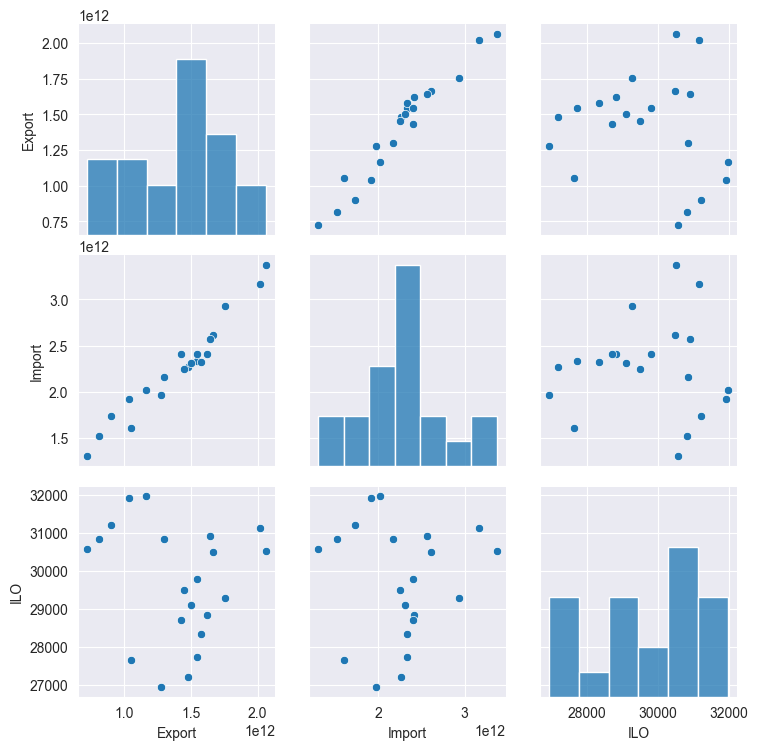

In [109]:
import seaborn as sns

g = sns.PairGrid(df_merge)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

#Conducting Regression Analysis - Wanonno Iqtyider

                            OLS Regression Results                            
Dep. Variable:            Q("Export")   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.4273
Date:                Sun, 27 Apr 2025   Prob (F-statistic):              0.521
Time:                        18:50:50   Log-Likelihood:                -587.86
No. Observations:                  21   AIC:                             1180.
Df Residuals:                      19   BIC:                             1182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.447e+12   1.59e+12      1.538      0.1

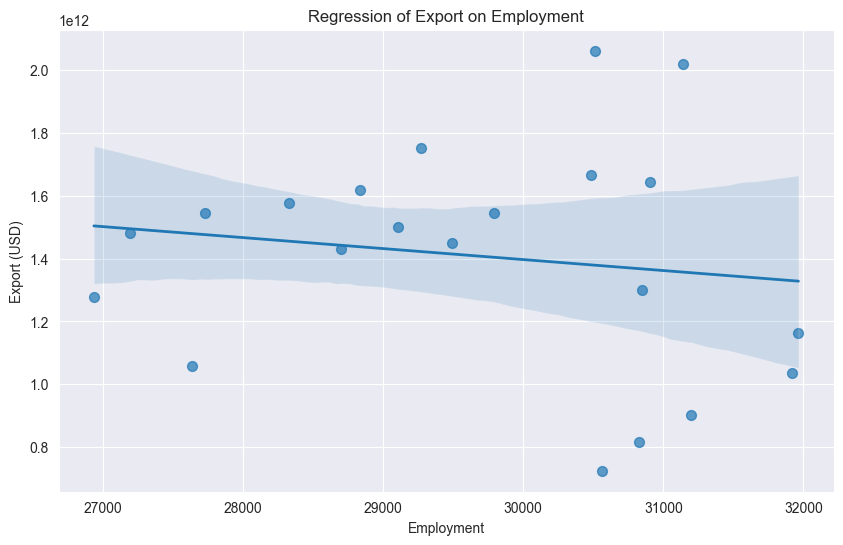

In [112]:
# 1. Import formula API
import statsmodels.formula.api as smf

# 2. Prepare the data
# Make sure 'employment' and 'total trade value' exist without NaNs
df_regression = df_merge.dropna(subset=["Export", "ILO"]).reset_index()

# 3. Run the regression using formula
# Note: you need to handle spaces in column names by using `Q("column name")` inside the formula
model = smf.ols(formula='Q("Export") ~ ILO', data=df_regression).fit()

# 4. Print regression summary
print(model.summary())

# 5. Visualize with regression line
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.regplot(
    data=df_regression,
    x="ILO",
    y="Export",
    scatter_kws={"s":50, "alpha":0.7},
    line_kws={"linewidth":2}
)
plt.title('Regression of Export on Employment')
plt.xlabel('Employment')
plt.ylabel('Export (USD)')
plt.grid(True)
plt.show()
